# 4.1) 타이타닉호의 생존자 가려내기

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

----------------------------------------------

# <Step1. 탐색> : Titanic 데이터 살펴보기

### 데이터 피처 설명
- pclass : Passenger Class, 승객 등급
- survived : 생존 여부
- name : 승객 이름
- sex : 승객 성별
- age : 승객 나이
- sibsp : 탑승 한 형제/배우자 수
- parch : 탑승 한 부모/자녀 수
- ticket : 티켓 번호
- fare : 승객 지불 요금
- cabin : 선실 이름
- embarked : 승선항 (C = 쉘 부르그, Q = 퀸즈타운, S = 사우스 햄튼)
- body : 사망자 확인 번호
- home.dest : 고향/목적지

In [53]:
df_train = pd.read_csv("../data/titanic_train.csv") # train용
df_test = pd.read_csv("../data/titanic_test.csv") # test용

In [54]:
df_train.head(5) # train용 먼저 살펴보기

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,body,home.dest
0,2,1,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.5000,NaN,S,NaN,"England / Bennington, VT"
1,2,1,"Wells, Miss. Joan",female,4.0,1,1,29103,23.0000,NaN,S,NaN,"Cornwall / Akron, OH"
2,2,1,"Duran y More, Miss. Florentina",female,30.0,1,0,SC/PARIS 2148,13.8583,NaN,C,NaN,"Barcelona, Spain / Havana, Cuba"
3,3,0,"Scanlan, Mr. James",male,NaN,0,0,36209,7.7250,NaN,Q,NaN,NaN
4,3,1,"Bradley, Miss. Bridget Delia",female,22.0,0,0,334914,7.7250,NaN,Q,NaN,"Kingwilliamstown, Co Cork, Ireland Glens Falls..."


In [55]:
print(df_train.info())
print("-----------------")
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     916 non-null    int64  
 1   survived   916 non-null    int64  
 2   name       916 non-null    object 
 3   sex        916 non-null    object 
 4   age        741 non-null    float64
 5   sibsp      916 non-null    int64  
 6   parch      916 non-null    int64  
 7   ticket     916 non-null    object 
 8   fare       916 non-null    float64
 9   cabin      214 non-null    object 
 10  embarked   914 non-null    object 
 11  body       85 non-null     float64
 12  home.dest  527 non-null    object 
dtypes: float64(3), int64(4), object(6)
memory usage: 93.2+ KB
None
-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     393 non-

In [56]:
# age, cabin, body, home.dest에는 결측치가 존재

### 불필요한 피처 제거

- 지금 당장에는 분석에 활용할 수 없음(name, cabin)
- 큰 의미를 가지고 있지 않음(ticket, home.dest,body)

In [57]:
# 데이터셋에서 name, ticket, body, cabin, home.dest 피처를 제거합니다.
df_train = df_train.drop(['name', 'ticket', 'body', 'cabin', 'home.dest'], axis=1) # axis=0 : 행 방향, axis=1 : 열 방향
df_test = df_test.drop(['name', 'ticket', 'body', 'cabin', 'home.dest'], axis=1) 

In [58]:
df_train

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,2,1,female,13.00,0,1,19.5000,S
1,2,1,female,4.00,1,1,23.0000,S
2,2,1,female,30.00,1,0,13.8583,C
3,3,0,male,NaN,0,0,7.7250,Q
4,3,1,female,22.00,0,0,7.7250,Q
...,...,...,...,...,...,...,...,...
911,3,1,female,0.17,1,2,20.5750,S
912,3,0,male,NaN,0,0,8.0500,S
913,3,1,female,NaN,0,0,7.7333,Q
914,2,1,female,20.00,0,0,36.7500,S


-----

### 탐색적 데이터 분석 (생존자 vs 비생존자)

In [59]:
print(df_train['survived'].value_counts()) # 생존=1, 아닌 경우=0

0    563
1    353
Name: survived, dtype: int64


<AxesSubplot: >

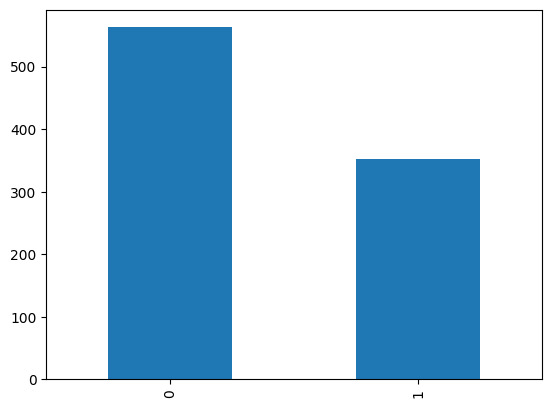

In [60]:
df_train['survived'].value_counts().plot.bar() # 시각적으로 확인

In [61]:
# survived 피처를 기준으로 그룹을 나누어, 그룹별 pclass 피처의 분포를 살펴봅니다.
print(df_train['pclass'].value_counts())

3    498
1    230
2    188
Name: pclass, dtype: int64


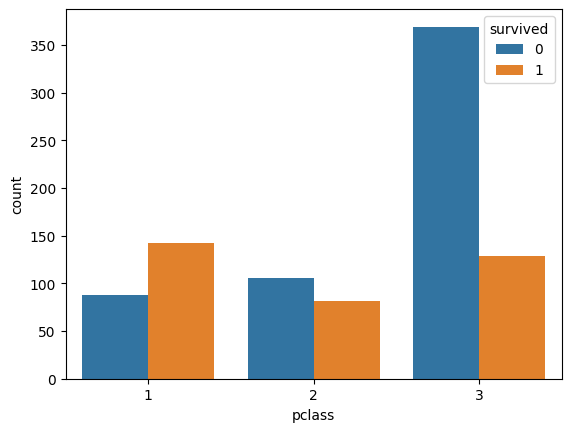

In [62]:
ax = sns.countplot(x='pclass', hue = 'survived',  data = df_train)
# x에는 알고자하는 column
# hue에 해당하는 column을 기준으로 데이터를 쪼갬

--------------

In [63]:
from scipy import stats

# 두 집단의 피처를 비교해주며 탐색작업을 자동화하는 함수를 정의합니다.
def valid_features(df, col_name, distribution_check=True):
    
    # 생존자 vs 비생존자 분포 확인(그래프를 통한 시각적 이해)
    g = sns.FacetGrid(df, col='survived')
    g.map(plt.hist, col_name, bins=30) # 히스토그램 그리기

    # 생존자들의 표준편차
    titanic_survived = df[df['survived']==1]
    titanic_survived_static = np.array(titanic_survived[col_name])
    print("(Survived)data std is", '%.2f' % np.std(titanic_survived_static))
    
    # 비생존자들의 표준편차
    titanic_n_survived = df[df['survived']==0]
    titanic_n_survived_static = np.array(titanic_n_survived[col_name])
    print("(Non_Survived)data std is", '%.2f' % np.std(titanic_n_survived_static))
    
     # T-test(집단 간 평균의 차이가 있는가?)
    tTestResult = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name]) # default는 분산이 같을 경우
    tTestResultDiffVar = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name], equal_var=False) # 분산이 다를 때
    print("(EqaulVar)The t-statistic and p-value assuming equal variances is %.3f and %.3f." % tTestResult)
    print("(DiffVar)The t-statistic and p-value not assuming equal variances is %.3f and %.3f" % tTestResultDiffVar)
    
    if distribution_check:
        # Shapiro-Wilk test ; 정규성 검정 ( 귀무가설은 정규분포를 따름 )
        print("(Survived)The w-statistic and p-value in Survived %.3f and %.3f" % stats.shapiro(titanic_survived[col_name]))
        print("(Non_Survived)The w-statistic and p-value in Non-Survived %.3f and %.3f" % stats.shapiro(titanic_n_survived[col_name]))

(Survived)data std is 14.22
(Non_Survived)data std is 13.71
(EqaulVar)The t-statistic and p-value assuming equal variances is -0.546 and 0.585.
(DiffVar)The t-statistic and p-value not assuming equal variances is -0.543 and 0.587
(Survived)The w-statistic and p-value in Survived 0.982 and 0.001
(Non_Survived)The w-statistic and p-value in Non-Survived 0.968 and 0.000


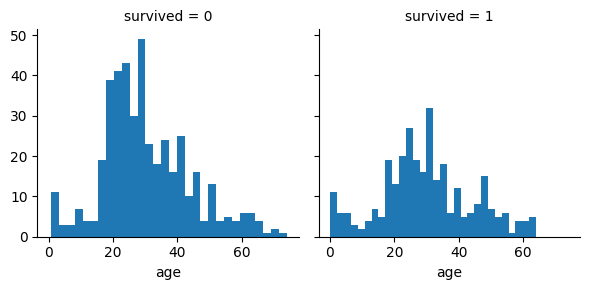

In [64]:
# 앞서 정의한 valid_features 함수를 실행합니다. age 피처를 탐색합니다.
valid_features(df_train[df_train['age'] > 0], 'age', distribution_check=True)

- T-test의 검정결과 : 어떤 방식으로든 p-value가 0.5보다 큼! 귀무가설 채택! .. 두 집단 간 평균 차이가 없음
- Shapiro-Test : 어떤 방식으로든 p-value가 0.5보다 훨씬 적음! 귀무가설 기각! .. 정규성 만족 X

(Survived)data std is 0.64
(Non_Survived)data std is 1.34
(EqaulVar)The t-statistic and p-value assuming equal variances is -2.118 and 0.034.
(DiffVar)The t-statistic and p-value not assuming equal variances is -2.446 and 0.015


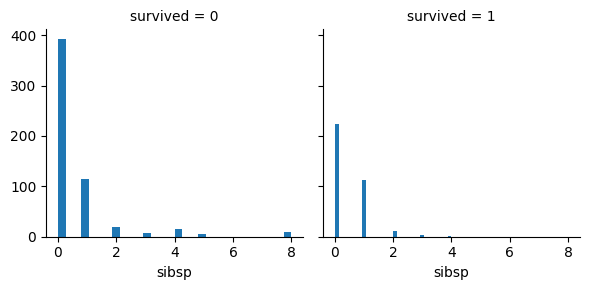

In [65]:
# 앞서 정의한 valid_features 함수를 실행합니다. sibsp 피처를 탐색합니다.
valid_features(df_train, 'sibsp', distribution_check=False)

- T-test의 검정결과 : 어떤 방식으로든 p-value가 0.5보다 큼! 귀무가설 채택! .. 두 집단 간 평균 차이가 있음!
- 여기서는 Shaipro-test가 나타나지 않음(distribution=False)

-----

### `[미니 퀴즈 - 4.1]`
- #### parch, fare, sex, embarked 피처에 대해 (생존자/비생존자) 간의 차이를 탐색해 보세요.

- ### 범주형 피처 >>> 시각적으로 분포만 확인

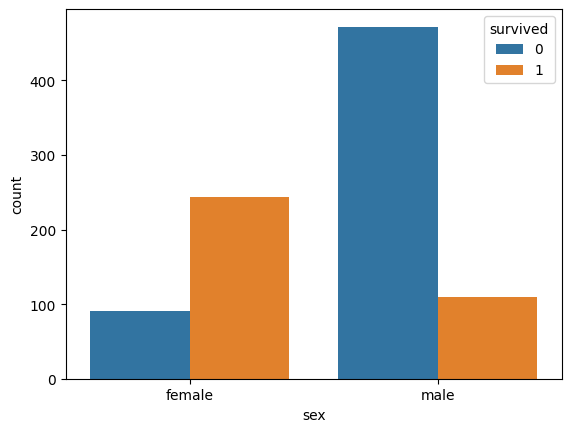

In [66]:
ax = sns.countplot(x='sex', hue = 'survived',  data = df_train)

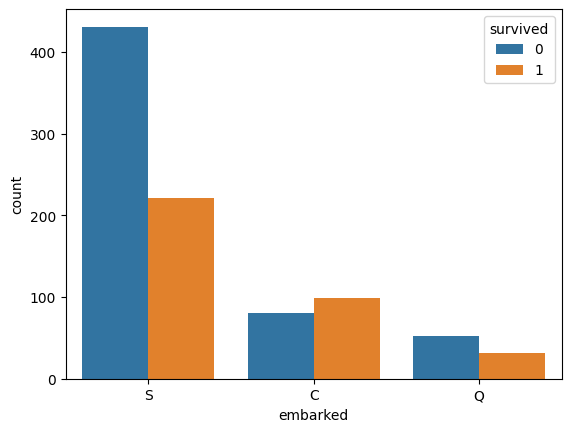

In [67]:
ax = sns.countplot(x='embarked', hue = 'survived',  data = df_train)

- ### 수치형 피처 : t-검정

(Survived)data std is 0.74
(Non_Survived)data std is 0.89
(EqaulVar)The t-statistic and p-value assuming equal variances is 1.865 and 0.063.
(DiffVar)The t-statistic and p-value not assuming equal variances is 1.942 and 0.052


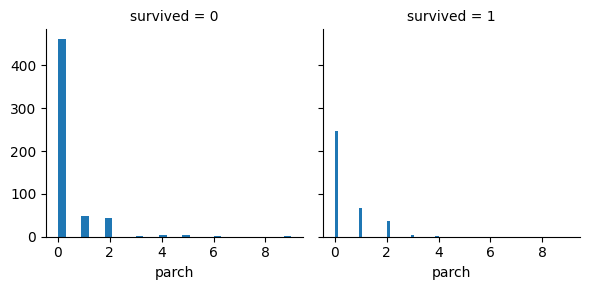

In [68]:
valid_features(df_train, 'parch', distribution_check=False)

- #### p-value > 0.05 (집단 간 평균 차이 X)

(Survived)data std is 60.68
(Non_Survived)data std is 33.65
(EqaulVar)The t-statistic and p-value assuming equal variances is 7.523 and 0.000.
(DiffVar)The t-statistic and p-value not assuming equal variances is 6.657 and 0.000


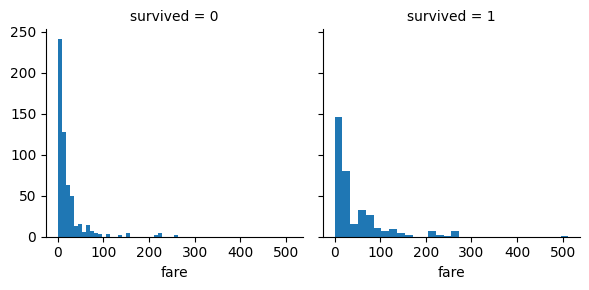

In [69]:
valid_features(df_train, 'fare', distribution_check=False)

- #### p-value < 0.05 (집단 간 평균 차이 O.. 심지어 매우 작음! 아주 유의미함)

-----

# <Step2. 분류> : 생존자 분류 모델 만들기

### 분류 모델을 위한 전처리(결측값 처리)

- #### 결측값을 삭제/대체

In [70]:
# # 결측값을 제외한 나머지의 평균 구하기
replace_mean = df_train[df_train['age'] > 0]['age'].mean() 

# 결측값을 위에서 구한 평균으로 대체
df_train['age'] = df_train['age'].fillna(replace_mean)
df_test['age'] = df_test['age'].fillna(replace_mean)
### train과 test는 분리돼야하는 게 아닌가? ###

In [71]:
# embarked 중 최빈값 저장
embarked_mode = df_train['embarked'].value_counts().index[0] # value_counts는 counts를 기준으로 내림차순

df_train['embarked'] = df_train['embarked'].fillna(embarked_mode)
df_test['embarked'] = df_test['embarked'].fillna(embarked_mode)

- #### 원-핫 인코딩 : 결측값 보정(범주형 변수 변환)

In [73]:
# 통합데이터(train + test) 생성 >>> one-hot encoding
whole_df = df_train.append(df_test)
train_idx_num = len(df_train)

# one-hot 인코딩
whole_df_encoded = pd.get_dummies(whole_df) # 3장_회귀분석에서 했던 dummy variable

df_train = whole_df_encoded[:train_idx_num]
df_test = whole_df_encoded[train_idx_num:]

df_train.head()

,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,2,1,13.000000,0,1,19.5000,1,0,0,0,1
1,2,1,4.000000,1,1,23.0000,1,0,0,0,1
2,2,1,30.000000,1,0,13.8583,1,0,1,0,0
3,3,0,30.231444,0,0,7.7250,0,1,0,1,0
4,3,1,22.000000,0,0,7.7250,1,0,0,1,0


In [74]:
# one-hot encoding 이후 다시 데이터 분리!
x_train, y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
x_test, y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values

-----

### 분류 모델링

#### Logistic Regression

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# random_state=0 : 랜덤 X
lr = LogisticRegression(random_state=0) 

# 로지스틱 모델
lr.fit(x_train, y_train) 

#### 분류 모델 평가

In [77]:
# test 데이터셋 넣어봐서 점검하기
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1] # 1이 될 확률 반환 : https://www.inflearn.com/questions/199841

print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))
# 이게 무엇인지는 앞으로 차차 설명하도록 하겠습니다 :)

accuracy: 0.80
Precision : 0.756
Recall : 0.673
F1 : 0.712


-----

### 분류 모델의 여러가지 평가 방법들 .. 교재 p.218쪽 참고
- Confusion Matrix 기반
    - Accuracy
    - Precision
    - Recall
    - F1 score : 정밀도와 재현도의 조화평균값
    - AUC (Area Under the Curve) & ROC (Receiver Operating Characteristic) curve : 재현도(민감도)와 특이도를 고려

In [79]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix를 출력합니다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred) # actual class <-> predicted class
print(confmat)

[[214  32]
 [ 48  99]]


-----

### Logistic Regression model AUC

그래프의 넓이 계산 .. 값이 1에 가까울수록 좋은 모델

In [80]:
from sklearn.metrics import roc_curve, roc_auc_score

# AUC (Area Under the Curve)를 계산하여 출력합니다 .. thresholds는 기준값이라고 생각하면 편함(https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=nilsine11202&logNo=221893136636)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

AUC : 0.838


AUC가 괜찮은 수준! 생존자를 잘 분류해내는 모델인 듯

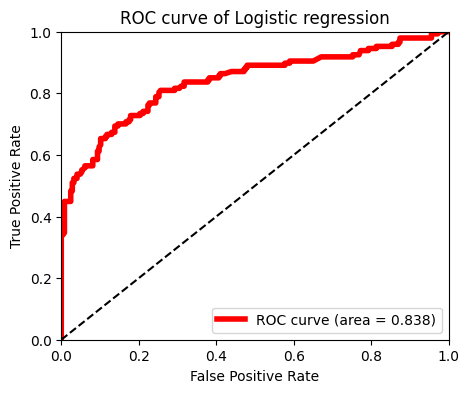

In [85]:
# ROC curve를 그래프로 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]

plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)

plt.plot([0, 1], [0, 1], 'k--') # k는 검은색 --는 점선을 나타낸다

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')

plt.title('ROC curve of Logistic regression')

plt.legend(loc="lower right") # 다른 것도 한 번 test해보기

-----

### Decision Tree(로지스틱 회귀모델 X)

In [88]:
from sklearn.tree import DecisionTreeClassifier

# 의사결정나무모델(Decision Tree) 만들기
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
y_pred_probability = dtc.predict_proba(x_test)[:,1] # test 데이터셋에 대한 예측확률값 반환

# 학습한 모델의 성능을 계산하여 출력합니다.
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.76
Precision : 0.693
Recall : 0.646
F1 : 0.669


In [89]:
# 학습한 모델의 AUC를 계산하여 출력합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

AUC : 0.746


평가지표가 로지스틱 회귀모델보다는 다 낮은 것을 확인할 수 있음(... 심지어 AUC값도 낮음)

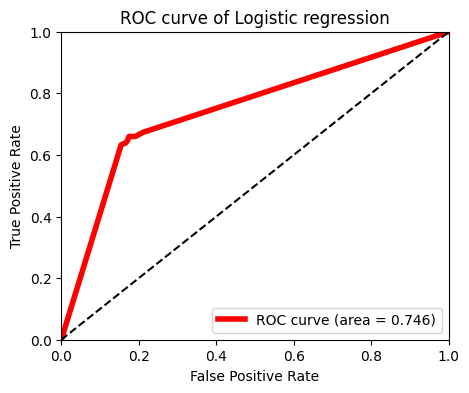

In [90]:
# ROC curve 시각화
plt.rcParams['figure.figsize'] = [5, 4]

plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve of Logistic regression')

plt.legend(loc="lower right")

-----

# <Step3. 모델 개선> : 피처 엔지니어링

분류모델의 성능을 더욱 끌어올리는 방법

### 피처에서 새로운 의미 추출해내기

In [91]:
# 데이터를 다시 불러옵니다.
df_train = pd.read_csv("../data/titanic_train.csv")
df_test = pd.read_csv("../data/titanic_test.csv")

df_train = df_train.drop(['ticket', 'body', 'home.dest'], axis=1) # Ch3에서 봤던 내용! axis=1을 열을 기준으로 한다는 의미
df_test = df_test.drop(['ticket', 'body', 'home.dest'], axis=1)

# age의 결측값을 평균값으로 대체합니다.
replace_mean = df_train[df_train['age'] > 0]['age'].mean()

df_train['age'] = df_train['age'].fillna(replace_mean)
df_test['age'] = df_test['age'].fillna(replace_mean) # 여기도 마찬가지,,?

# embark : 2개의 결측값을 최빈값으로 대체합니다.
embarked_mode = df_train['embarked'].value_counts().index[0]

df_train['embarked'] = df_train['embarked'].fillna(embarked_mode)
df_test['embarked'] = df_test['embarked'].fillna(embarked_mode)

# one-hot encoding을 위한 통합 데이터 프레임(whole_df)을 생성합니다.
whole_df = df_train.append(df_test)
train_idx_num = len(df_train)

### cabin(선실 이름) 피처 활용하기

In [92]:
print(whole_df['cabin'].value_counts()[:10])

C23 C25 C27        6
B57 B59 B63 B66    5
G6                 5
F4                 4
B96 B98            4
F33                4
C78                4
D                  4
F2                 4
C22 C26            4
Name: cabin, dtype: int64


In [96]:
# 결측값 처리
whole_df['cabin'] = whole_df['cabin'].fillna('X')

# cabin 피처의 첫 번째 문자를 인덱싱 및 cabin 피처 알아보기
whole_df['cabin'] = whole_df['cabin'].apply(lambda x: x[0])
whole_df['cabin'].value_counts()

X    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: cabin, dtype: int64

In [97]:
# 추출한 문자 중, G와 T는 수가 너무 작기 때문에, 마찬가지로 ‘X’로 대체합니다.(피처 엔지니어링)
whole_df['cabin'] = whole_df['cabin'].replace({"G":"X", "T":"X"})
whole_df['cabin'].value_counts()

X    1020
C      94
B      65
D      46
E      41
A      22
F      21
Name: cabin, dtype: int64

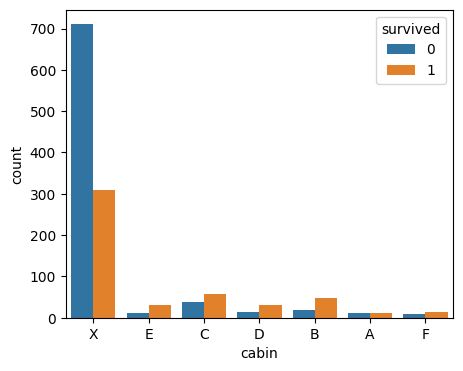

In [98]:
# 시각화
ax = sns.countplot(x='cabin', hue = 'survived',  data = whole_df)
plt.show()

    생존자와 비생존자 그룹 간에 유의미한 차이가 있어보임!

-----

### name(승객 이름) 피처 활용하기

In [104]:
# 데이터 살펴보기
whole_df['name'].head(10)

0    Mellinger, Miss. Madeleine Violet
1                    Wells, Miss. Joan
2       Duran y More, Miss. Florentina
3                   Scanlan, Mr. James
4         Bradley, Miss. Bridget Delia
5                 Linehan, Mr. Michael
6       Francatelli, Miss. Laura Mabel
7             Quick, Miss. Phyllis May
8             Thayer, Mr. John Borland
9     Silverthorne, Mr. Spencer Victor
Name: name, dtype: object

In [105]:
# 이름에서 호칭을 추출합니다.
name_grade = whole_df['name'].apply(lambda x : x.split(", ",maxsplit=1)[1].split(".")[0])
name_grade = name_grade.unique().tolist()
print(name_grade)

['Miss', 'Mr', 'Master', 'Mrs', 'Dr', 'Mlle', 'Col', 'Rev', 'Ms', 'Mme', 'Sir', 'the Countess', 'Dona', 'Jonkheer', 'Lady', 'Major', 'Don', 'Capt']


In [106]:
# 호칭에 따라 사회적 지위(1910년대 기준)를 정의합니다.
grade_dict = {'A': ['Rev', 'Col', 'Major', 'Dr', 'Capt', 'Sir'], # 명예직을 나타냅니다.
              'B': ['Ms', 'Mme', 'Mrs', 'Dona'], # 여성을 나타냅니다.
              'C': ['Jonkheer', 'the Countess'], # 귀족이나 작위를 나타냅니다.
              'D': ['Mr', 'Don'], # 남성을 나타냅니다.
              'E': ['Master'], # 젊은남성을 나타냅니다.
              'F': ['Miss', 'Mlle', 'Lady']} # 젊은 여성을 나타냅니다.

# 정의한 호칭의 기준에 따라, A~F의 문자로 name 피처를 다시 정의하는 함수입니다.
def give_grade(x):
    grade = x.split(", ", 1)[1].split(".")[0]
    for key, value in grade_dict.items():
        for title in value:
            if grade == title:
                return key
    return 'G'
    
# 피처 엔지니어링
whole_df['name'] = whole_df['name'].apply(lambda x: give_grade(x))
print(whole_df['name'].value_counts())

D    758
F    263
B    201
E     61
A     24
C      2
Name: name, dtype: int64


------

### `[미니 퀴즈 - 4.2]`
- `‘cabin’ 피처와 마찬가지로, ‘name’ 피처에 대해 (생존자/비생존) 그룹 간의 차이를 탐색해 보세요.` 
    - 위와 동일한 방법을 이용하여 생존자와 비생존자 그룹간의 분포가 어떻게 다른지, 시각적으로 탐색해보도록 합시다.
        - countplot으로 시각화!

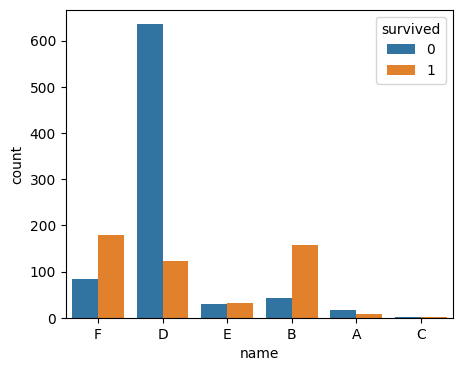

In [110]:
ax = sns.countplot(x='name', hue = 'survived',  data = whole_df)
plt.show()

name 피처는 그렇게 유의미해보이진 않음

In [108]:
# from scipy import stats

# chis = stats.chisquare(whole_df[whole_df['survived']==1]['cabin'].value_counts().sort_index(), 
                       # whole_df[whole_df['survived']==0]['cabin'].value_counts().sort_index())
# print("statistic = %.3f, pvalue = %.3f" % chis)

-----

### one-hot encoding

"모든" 범주형 피처들을 대상으로 한 원-핫 인코딩

In [111]:
# pandas 패키지를 이용한 one-hot 인코딩을 수행합니다.
whole_df_encoded = pd.get_dummies(whole_df)

df_train = whole_df_encoded[:train_idx_num]
df_test = whole_df_encoded[train_idx_num:]

df_train.head()

,pclass,survived,age,sibsp,parch,fare,name_A,name_B,name_C,name_D,...,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_X,embarked_C,embarked_Q,embarked_S
0,2,1,13.000000,0,1,19.5000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,2,1,4.000000,1,1,23.0000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,2,1,30.000000,1,0,13.8583,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,3,0,30.231444,0,0,7.7250,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
4,3,1,22.000000,0,0,7.7250,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


-----

### 피처 엔지니어링이 완료된 데이터학습

In [116]:
# 데이터를 학습 데이터셋, 테스트 데이터셋으로 분리합니다 .. 생존자 <-> 비생존자
x_train, y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values 
x_test, y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values

# 로지스틱 회귀 모델을 학습합니다.
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

# 학습한 모델의 테스트 데이터셋에 대한 예측 결과를 반환합니다.
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 테스트 데이터셋에 대한 accuracy, precision, recall, f1 평가 지표를 각각 출력합니다.
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred)) # AUC (Area Under the Curve) & ROC curve

# AUC (Area Under the Curve)를 계산하여 출력합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

accuracy: 0.79
Precision : 0.736
Recall : 0.701
F1 : 0.718
AUC : 0.853


accurach와 precision은 조금 감소, .. But, F1 score & AUC는 많이 상승!

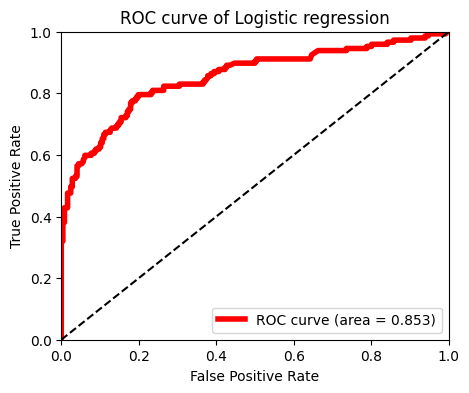

In [117]:
# ROC curve를 그래프로 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve of Logistic regression')

plt.legend(loc="lower right")

-----

### 피처 영향력 살펴보기

In [124]:
# 예측 대상인 survived 피처를 제외한 모든 피처를 리스트로 반환합니다. (그래프의 y축)
cols = df_train.columns.tolist()
cols.remove('survived')

cols

['pclass',
 'age',
 'sibsp',
 'parch',
 'fare',
 'name_A',
 'name_B',
 'name_C',
 'name_D',
 'name_E',
 'name_F',
 'sex_female',
 'sex_male',
 'cabin_A',
 'cabin_B',
 'cabin_C',
 'cabin_D',
 'cabin_E',
 'cabin_F',
 'cabin_X',
 'embarked_C',
 'embarked_Q',
 'embarked_S']

In [121]:
y_pos = np.arange(len(cols))
y_pos

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

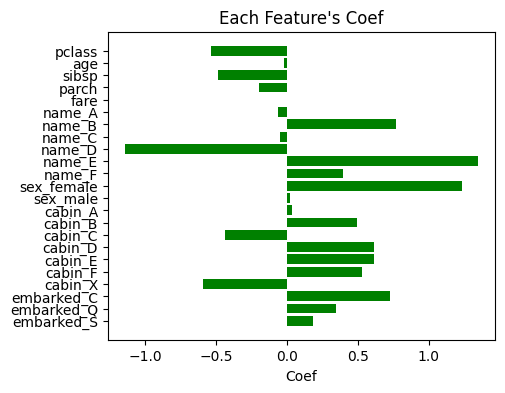

In [125]:
# 각 피처별 회귀 분석 계수를 그래프의 x축으로 하여, 피처 영향력 그래프를 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]

fig, ax = plt.subplots()
ax.barh(y_pos, lr.coef_[0], align='center', color='green', ecolor='black')

ax.set_yticks(y_pos) # np.arange로 먼저 y축 대응
ax.set_yticklabels(cols) # 후에 원래 이름으로 돌리기

ax.invert_yaxis()

ax.set_xlabel('Coef')

ax.set_title("Each Feature's Coef")

plt.show()

-----

# <Step4. 평가> : 모델 검증하기

### 1) K-fold 교차 검증 수행하기

테스트셋 데이터셋의 불균형 가능성을 낮춰주는 방법.. 교재 p.231

K개의 데이터 셋 -> K번 만큼 학습 & 검증

- K-fold 교차 검증을 통한 과적합 검증

In [129]:
from sklearn.model_selection import KFold

# K-fold 교차 검증의 k를 5로 설정합니다.
k = 5
cv = KFold(k, shuffle=True, random_state=0)
acc_history = []

# K-fold를 5번의 분할 학습으로 반복합니다.
for i, (train_data_row, test_data_row) in enumerate(cv.split(whole_df_encoded)): # 전에 설정했던 dummy variable

    # 5개로 분할된 fold 중 4개를 학습 데이터셋, 1개를 테스트 데이터셋으로 지정합니다. 매 반복시마다, 테스트 데이터셋은 변경됩니다.
    df_train = whole_df_encoded.iloc[train_data_row]
    df_test = whole_df_encoded.iloc[test_data_row]
    
    # survived 피처를 y, 나머지 피처들을 x 데이터로 지정합니다.
    splited_x_train, splited_y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
    splited_x_test, splited_y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values
    
    # 주어진 데이터로 로지스틱 회귀 모델을 학습합니다.
    lr = LogisticRegression(random_state=0)
    lr.fit(splited_x_train, splited_y_train)
    y_pred = lr.predict(splited_x_test)
    
    # 테스트 데이터셋의 Accuracy를 계산하여 acc_history에 저장합니다.
    splited_acc = accuracy_score(splited_y_test, y_pred)
    acc_history.append(splited_acc)

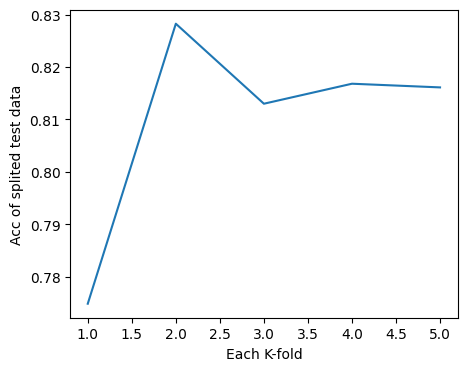

In [130]:
# acc_history에 저장된 5번의 학습 결과(Accuracy)를 그래프로 출력합니다.
plt.xlabel("Each K-fold")
plt.ylabel("Acc of splited test data")

plt.plot(range(1, k+1), acc_history)

AUC가 매 번 큰폭으로 변화하고 있음 .. 불안정함

-----

### 2) 학습 곡선 분석하기

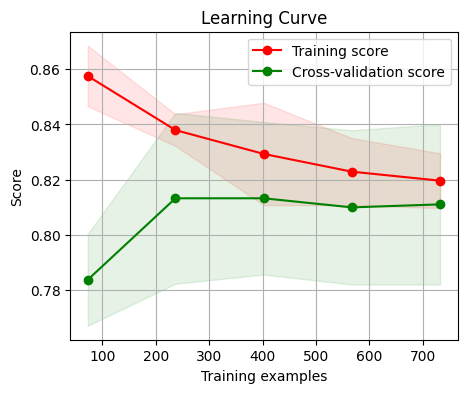

In [133]:
import scikitplot as skplt
skplt.estimators.plot_learning_curve(lr, x_train, y_train)
plt.show()

데이터의 개수가 300개보다 크면 과적합의 위험이 낮아진 것을 알 수 있음